In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Загрузка данных из файла
data_train = pd.read_csv('DailyDelhiClimateTrain.csv', index_col='date')

In [2]:
data_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col='date')

In [3]:
df = pd.merge(data_train, data_test, how='outer', on=['date', 'meantemp', 'humidity', 'wind_speed', 'meanpressure'])

In [4]:
# Remove obvious outliers
df_filtered = df[(df['meanpressure'] >= 900) & (df['meanpressure'] <= 1400)]

In [5]:
df_filtered

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


In [6]:
# Feature columns
features = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']

In [7]:
# Normalize the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

In [8]:
# Convert scaled data to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=features, index=df.index)

In [9]:
scaled_df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,0.122271,0.820957,0.000000,0.132603
2013-01-02,0.042795,0.907591,0.070583,0.132881
2013-01-03,0.035662,0.849835,0.109743,0.132994
2013-01-04,0.081514,0.668867,0.029212,0.132799
2013-01-05,0.000000,0.847910,0.087636,0.132712
...,...,...,...,...
2017-04-20,0.871179,0.162541,0.131750,0.130385
2017-04-21,0.863537,0.299711,0.164910,0.130548
2017-04-22,0.822271,0.317327,0.210564,0.130772


In [10]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)


In [11]:
window_size = 10

# Create sequences
X, y = create_sequences(scaled_df.values, window_size)

In [12]:
len(X), len(y)

(1566, 1566)

In [13]:
# Split the sequences
X_train = X[:-113]
X_test = X[-113:]
y_train = y[:-113]
y_test = y[-113:]

In [14]:
from tensorflow.keras.callbacks import Callback

class PrintEvery10thEpoch(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:  # +1 because epoch indexing starts at 0
            print(f"Epoch {epoch + 1}, Loss: {logs['loss']}, Val Loss: {logs.get('val_loss')}")

# LSTM Model

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define the LSTM model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.007851535454392433, Val Loss: 0.007918277755379677
Epoch 20, Loss: 0.0070160143077373505, Val Loss: 0.007184913381934166
Epoch 30, Loss: 0.006620057392865419, Val Loss: 0.006764369551092386
Epoch 40, Loss: 0.0061490656808018684, Val Loss: 0.006293837446719408
Epoch 50, Loss: 0.005587790627032518, Val Loss: 0.005744743160903454
Epoch 60, Loss: 0.005457942374050617, Val Loss: 0.005575695540755987
Epoch 70, Loss: 0.005423783324658871, Val Loss: 0.00554300332441926
Epoch 80, Loss: 0.005214013624936342, Val Loss: 0.005239692982286215
Epoch 90, Loss: 0.005185640417039394, Val Loss: 0.005234354641288519
Epoch 100, Loss: 0.0050704386085271835, Val Loss: 0.005342232063412666


In [16]:
# Make predictions on the test set
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step


In [17]:
len(predictions), len(y_test)

(113, 113)

In [18]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

In [19]:
# Evaluate on the test set
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0042 
Test Loss: 0.004333509132266045


In [20]:
predictions_inverse

array([[  13.917166 ,   81.559006 ,    5.7355523,  868.39594  ],
       [  15.5667925,   76.98165  ,    6.5081806,  850.46436  ],
       [  15.930784 ,   80.40526  ,    6.168079 ,  899.31506  ],
       [  16.906002 ,   72.118515 ,    7.228823 ,  888.35394  ],
       [  17.139915 ,   75.74541  ,    6.3144984,  947.7232   ],
       [  17.302958 ,   77.10296  ,    6.9180813,  964.7214   ],
       [  15.613607 ,   87.21428  ,    5.413688 , 1065.1036   ],
       [  15.88383  ,   80.08844  ,    5.301574 ,  973.91864  ],
       [  15.1439495,   78.14032  ,    5.4081225,  985.0384   ],
       [  14.218717 ,   71.578156 ,    6.0082784,  990.9468   ],
       [  13.009805 ,   71.591934 ,    5.749196 , 1035.1023   ],
       [  12.441212 ,   72.40948  ,    5.316619 , 1030.2489   ],
       [  12.935788 ,   66.74731  ,    6.0646844,  987.2602   ],
       [  12.933807 ,   72.22171  ,    5.522723 , 1013.23267  ],
       [  14.242537 ,   71.1029   ,    6.0231943,  958.2104   ],
       [  14.197553 ,   7

In [21]:
y_test_inverse

array([[  18.5       ,   77.22222222,    2.89444444, 1018.27777778],
       [  17.11111111,   81.88888889,    4.01666667, 1018.33333333],
       [  18.7       ,   70.05      ,    4.545     , 1015.7       ],
       [  18.38888889,   74.94444444,    3.3       , 1014.33333333],
       [  19.31818182,   79.31818182,    8.68181818, 1011.77272727],
       [  14.70833333,   95.83333333,   10.04166667, 1011.375     ],
       [  15.68421053,   83.52631579,    1.95      , 1015.55      ],
       [  14.57142857,   80.80952381,    6.54285714, 1015.95238095],
       [  12.11111111,   71.94444444,    9.36111111, 1016.88888889],
       [  11.        ,   72.11111111,    9.77222222, 1016.77777778],
       [  11.78947368,   74.57894737,    6.62631579, 1016.36842105],
       [  13.23529412,   67.05882353,    6.43529412, 1017.52941176],
       [  13.2       ,   74.28      ,    5.276     , 1018.84      ],
       [  16.43478261,   72.56521739,    3.63043478, 1018.13043478],
       [  14.65      ,   78.45    

In [22]:
evaluation_map = {}

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

evaluation_map['LSTM'] = {}
evaluation_map['LSTM']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['LSTM']['MAE'] = mean_absolute_error(y_test, predictions)

In [24]:
print(evaluation_map)

{'LSTM': {'MSE': 0.004333508798336236, 'MAE': 0.04614190338943056}}


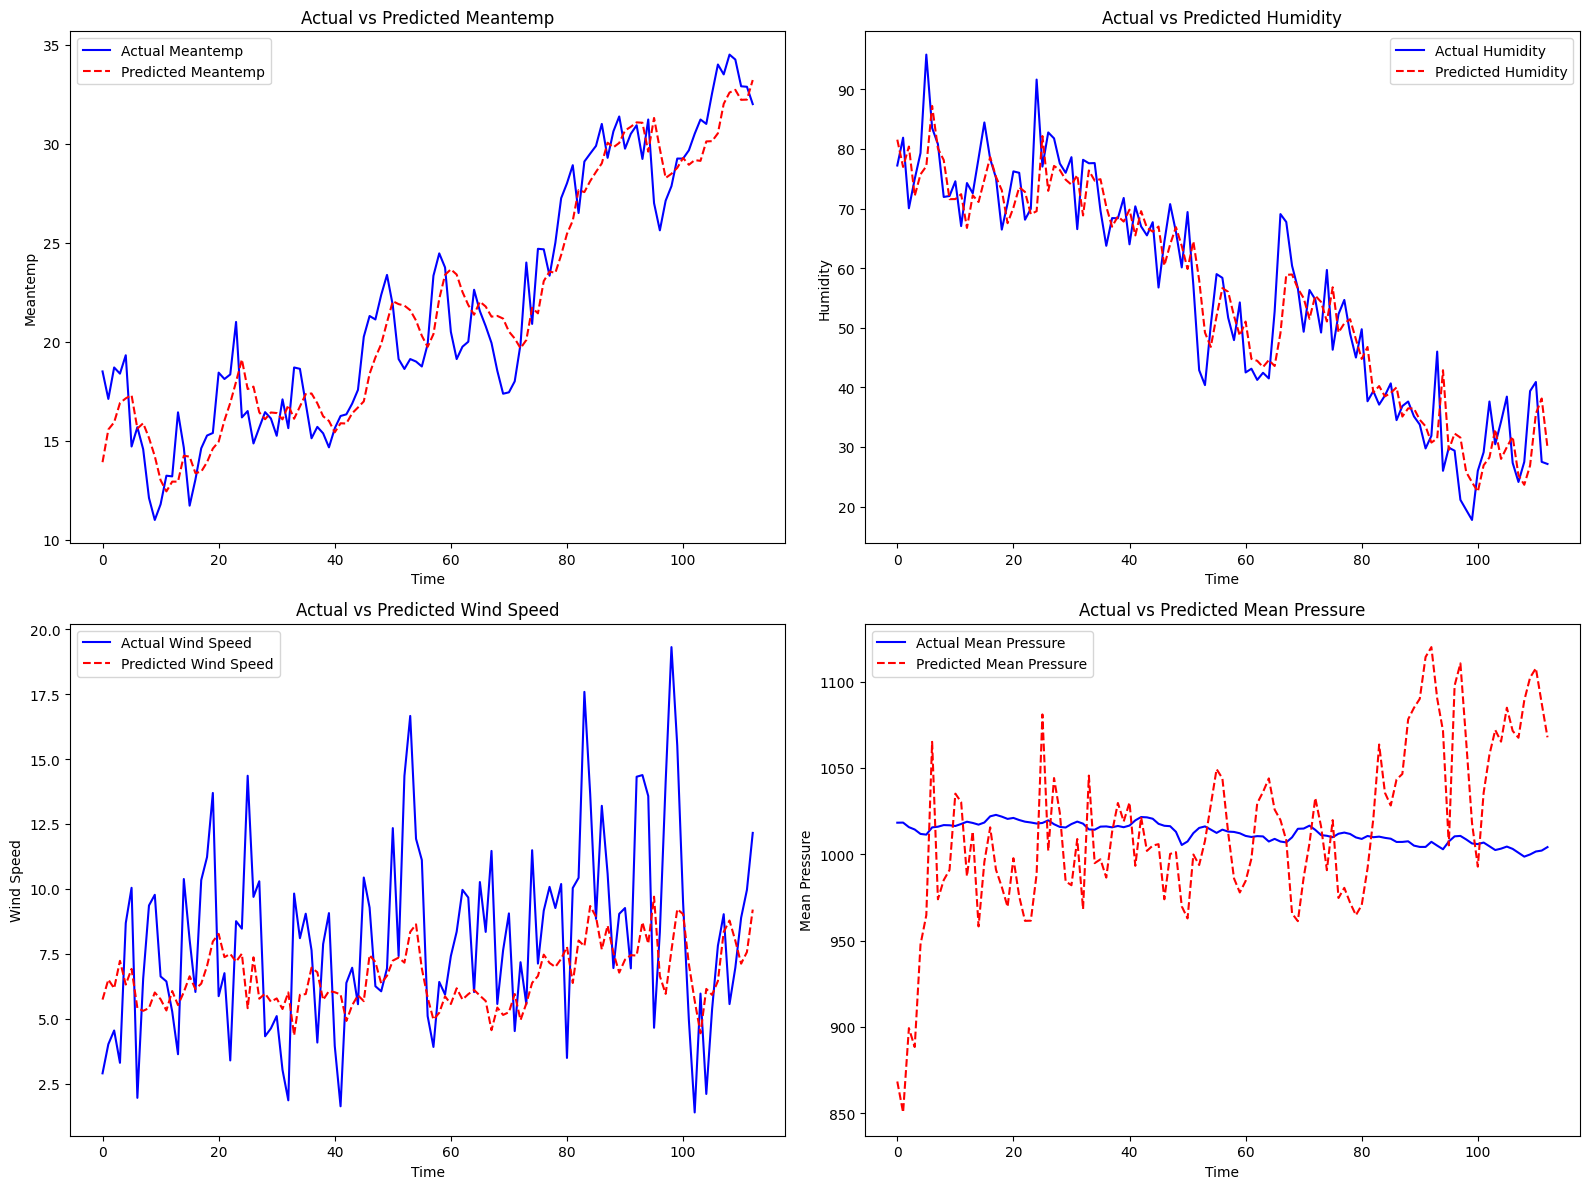

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume predictions_inverse and y_test_inverse are available and shaped correctly
# Split the predictions and actual values by feature
predictions_meantemp = predictions_inverse[:, 0]
predictions_humidity = predictions_inverse[:, 1]
predictions_wind_speed = predictions_inverse[:, 2]
predictions_meanpressure = predictions_inverse[:, 3]

y_test_meantemp = y_test_inverse[:, 0]
y_test_humidity = y_test_inverse[:, 1]
y_test_wind_speed = y_test_inverse[:, 2]
y_test_meanpressure = y_test_inverse[:, 3]

# Create DataFrames for each feature
plot_df_meantemp = pd.DataFrame({
    'Actual': y_test_meantemp,
    'Predicted': predictions_meantemp
}, index=pd.RangeIndex(start=0, stop=len(y_test_meantemp), step=1))

plot_df_humidity = pd.DataFrame({
    'Actual': y_test_humidity,
    'Predicted': predictions_humidity
}, index=pd.RangeIndex(start=0, stop=len(y_test_humidity), step=1))

plot_df_wind_speed = pd.DataFrame({
    'Actual': y_test_wind_speed,
    'Predicted': predictions_wind_speed
}, index=pd.RangeIndex(start=0, stop=len(y_test_wind_speed), step=1))

plot_df_meanpressure = pd.DataFrame({
    'Actual': y_test_meanpressure,
    'Predicted': predictions_meanpressure
}, index=pd.RangeIndex(start=0, stop=len(y_test_meanpressure), step=1))

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# GRU Model

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.006395903415977955, Val Loss: 0.00648597814142704
Epoch 20, Loss: 0.005693358369171619, Val Loss: 0.005554002244025469
Epoch 30, Loss: 0.005427256692200899, Val Loss: 0.005335586611181498
Epoch 40, Loss: 0.005237451288849115, Val Loss: 0.005137678701430559
Epoch 50, Loss: 0.005243727471679449, Val Loss: 0.005188484210520983
Epoch 60, Loss: 0.0051225353963673115, Val Loss: 0.00507628358900547
Epoch 70, Loss: 0.005118700210005045, Val Loss: 0.004968332592397928
Epoch 80, Loss: 0.005059124901890755, Val Loss: 0.004944257903844118
Epoch 90, Loss: 0.004970951937139034, Val Loss: 0.004981278441846371
Epoch 100, Loss: 0.004920267965644598, Val Loss: 0.004977887496352196


In [27]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [28]:
evaluation_map['GRU'] = {}
evaluation_map['GRU']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['GRU']['MAE'] = mean_absolute_error(y_test, predictions)

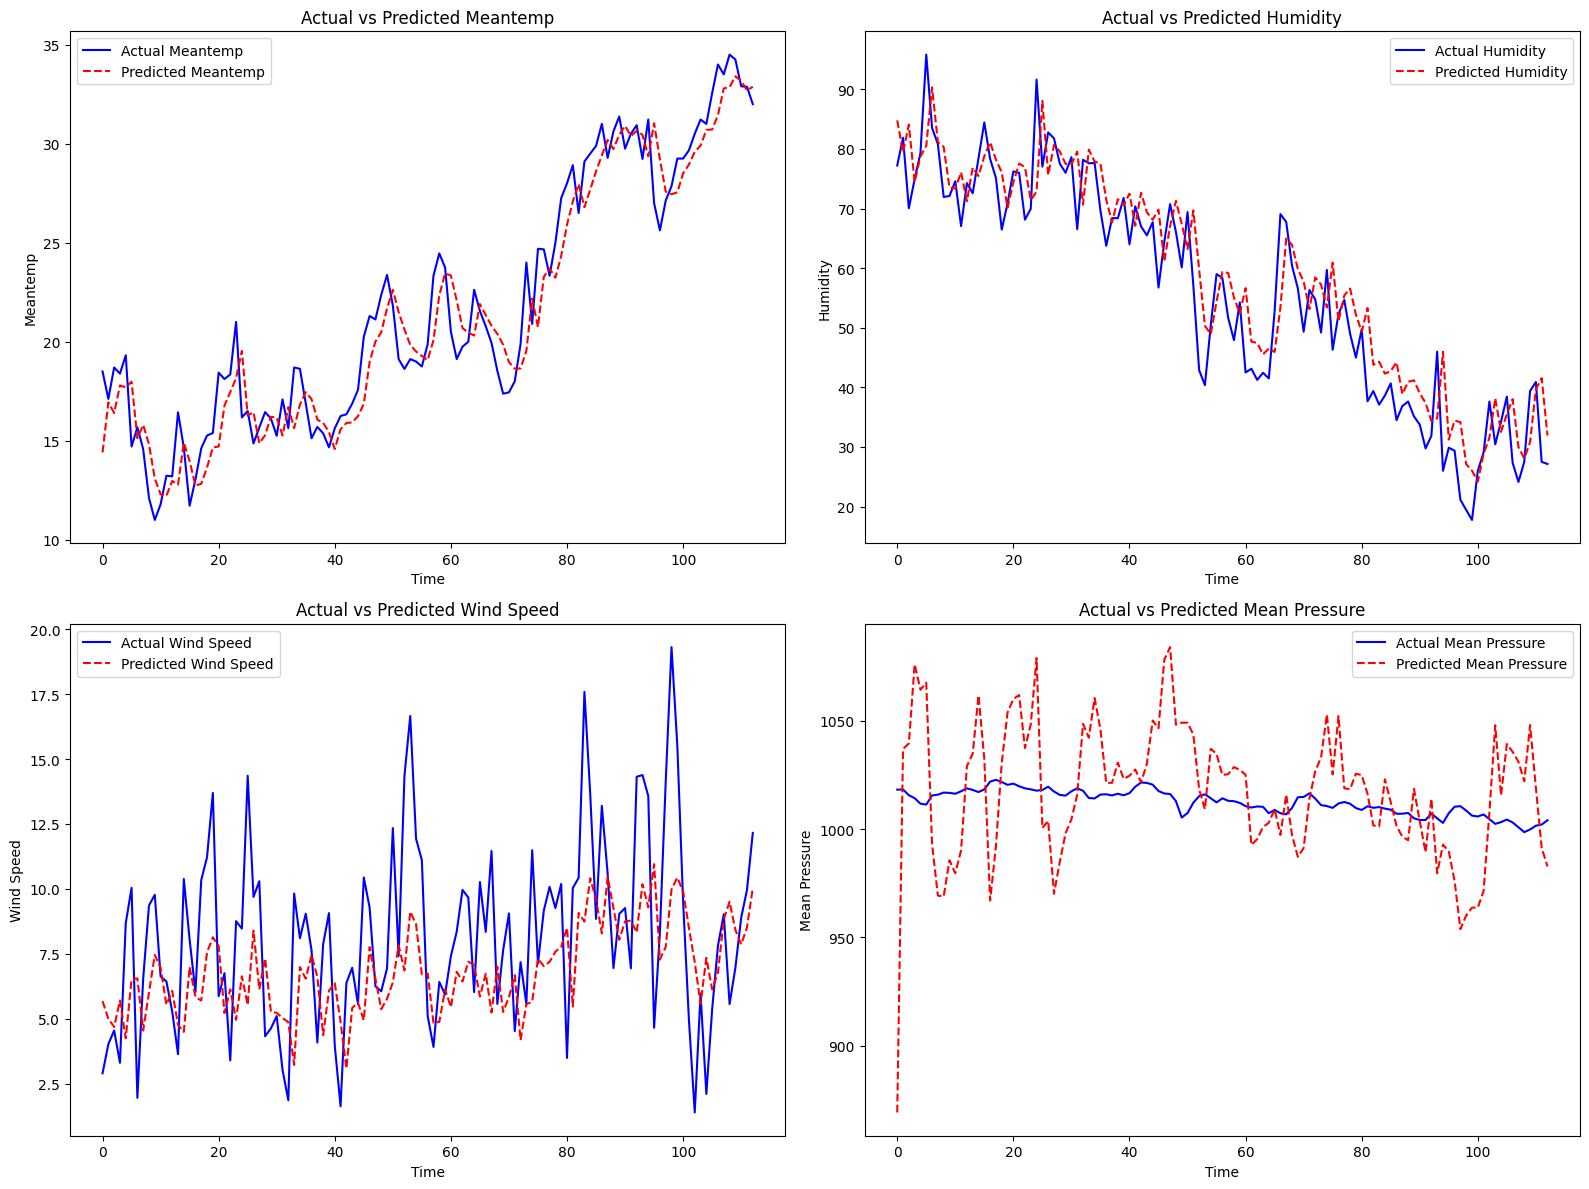

In [29]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


# RNN Model

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(SimpleRNN(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.0062132300809025764, Val Loss: 0.0065507907420396805
Epoch 20, Loss: 0.005607978906482458, Val Loss: 0.006124872714281082
Epoch 30, Loss: 0.005332890897989273, Val Loss: 0.005472342483699322
Epoch 40, Loss: 0.005014190915971994, Val Loss: 0.0055600423365831375
Epoch 50, Loss: 0.004907379392534494, Val Loss: 0.005234851501882076
Epoch 60, Loss: 0.004847048781812191, Val Loss: 0.005206278525292873
Epoch 70, Loss: 0.0047597759403288364, Val Loss: 0.0051978882402181625
Epoch 80, Loss: 0.0046267262659966946, Val Loss: 0.005237988196313381
Epoch 90, Loss: 0.004520511254668236, Val Loss: 0.005326630547642708
Epoch 100, Loss: 0.004536230117082596, Val Loss: 0.0054124342277646065


In [31]:
# Make predictions
predictions = model.predict(X_test)

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001E51BE36FC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [32]:
evaluation_map['RNN'] = {}
evaluation_map['RNN']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['RNN']['MAE'] = mean_absolute_error(y_test, predictions)

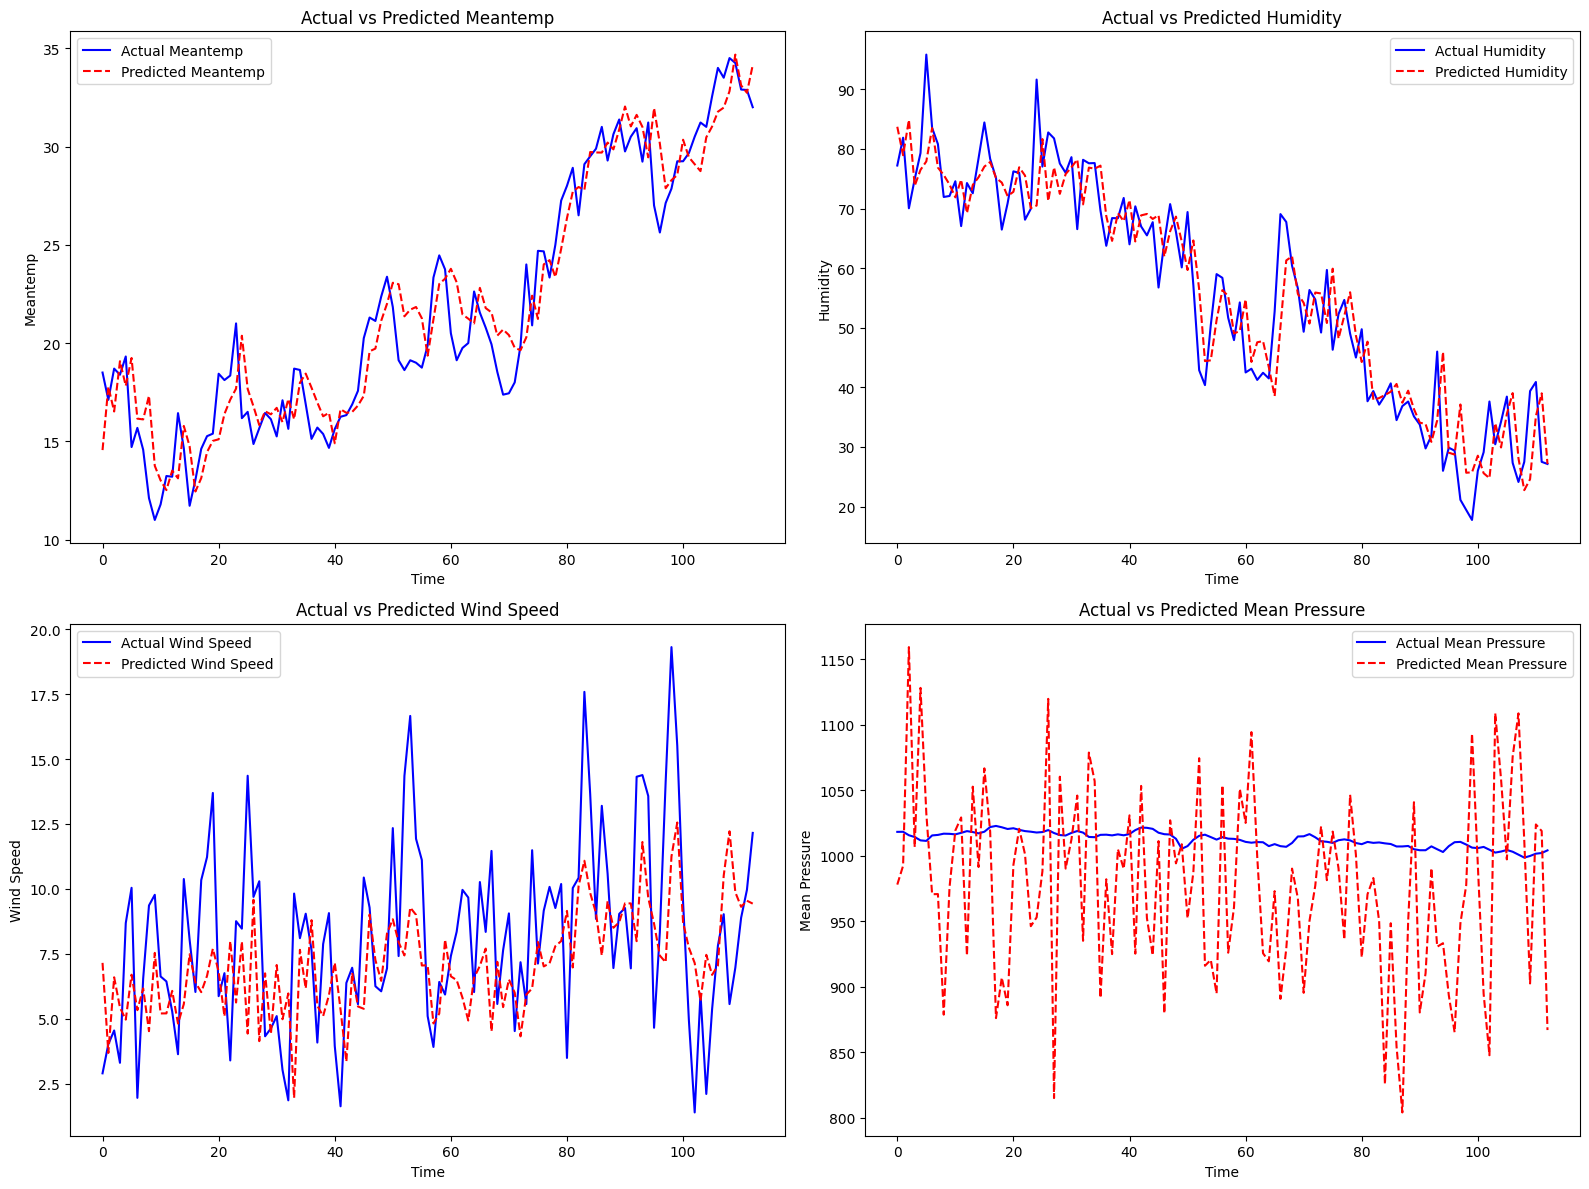

In [33]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# Attention Mechanism with LSTM

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionMechanism(Layer):
    def __init__(self, return_sequences=True):
        super(AttentionMechanism, self).__init__()
        self.return_sequences = return_sequences

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),
                               initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),
                               initializer="zeros")

    def call(self, x):
        e = tf.nn.tanh(tf.matmul(x,self.W)+self.b)
        a = tf.nn.softmax(e, axis=1)
        output = x*a

        if self.return_sequences:
            return output

        return tf.reduce_sum(output, axis=1)


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(AttentionMechanism(return_sequences=True))  # Внимание после LSTM
model.add(LSTM(32, return_sequences=False))
model.add(Dense(4))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 10, Loss: 0.008759991265833378, Val Loss: 0.009371721185743809
Epoch 20, Loss: 0.00805487297475338, Val Loss: 0.008157787844538689
Epoch 30, Loss: 0.007308679167181253, Val Loss: 0.0073754810728132725
Epoch 40, Loss: 0.006971817929297686, Val Loss: 0.0073945908807218075
Epoch 50, Loss: 0.006405719090253115, Val Loss: 0.00663557555526495
Epoch 60, Loss: 0.006042622961103916, Val Loss: 0.006012760102748871
Epoch 70, Loss: 0.006090026814490557, Val Loss: 0.006036603357642889
Epoch 80, Loss: 0.005809014197438955, Val Loss: 0.005423524416983128
Epoch 90, Loss: 0.005573589354753494, Val Loss: 0.00640737172216177
Epoch 100, Loss: 0.005391682498157024, Val Loss: 0.005163622088730335


In [36]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


In [37]:
evaluation_map['LSTM with Attention'] = {}
evaluation_map['LSTM with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['LSTM with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

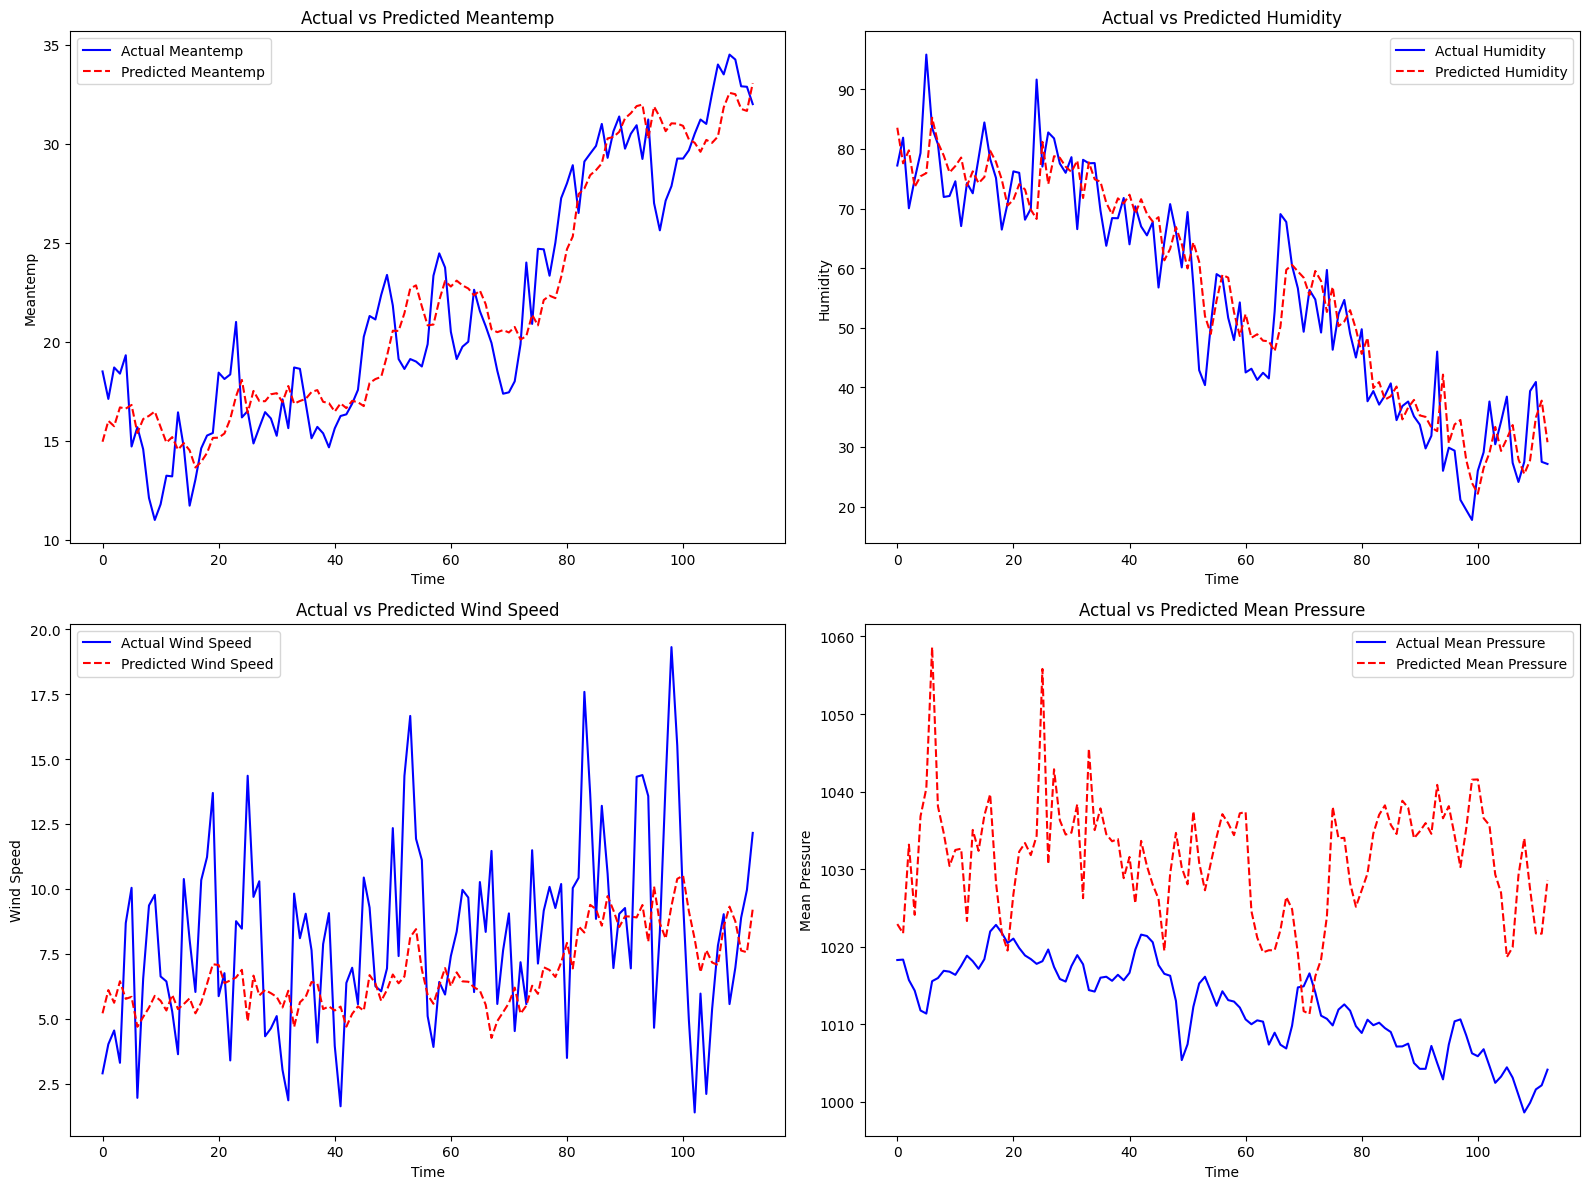

In [38]:
# Reverse normalization for predictions and actual values
predictions_inverse = scaler.inverse_transform(predictions)
y_test_inverse = scaler.inverse_transform(y_test)

# Create DataFrames for plotting each feature
def create_plot_df(predictions, actuals):
    return pd.DataFrame({
        'Actual': actuals.flatten(),
        'Predicted': predictions.flatten()
    })

plot_df_meantemp = create_plot_df(predictions_inverse[:, 0], y_test_inverse[:, 0])
plot_df_humidity = create_plot_df(predictions_inverse[:, 1], y_test_inverse[:, 1])
plot_df_wind_speed = create_plot_df(predictions_inverse[:, 2], y_test_inverse[:, 2])
plot_df_meanpressure = create_plot_df(predictions_inverse[:, 3], y_test_inverse[:, 3])

# Plot each feature
plt.figure(figsize=(16, 12))

# Plot for meantemp
plt.subplot(2, 2, 1)
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Actual'], label='Actual Meantemp', color='blue')
plt.plot(plot_df_meantemp.index, plot_df_meantemp['Predicted'], label='Predicted Meantemp', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Meantemp')
plt.title('Actual vs Predicted Meantemp')
plt.legend()

# Plot for humidity
plt.subplot(2, 2, 2)
plt.plot(plot_df_humidity.index, plot_df_humidity['Actual'], label='Actual Humidity', color='blue')
plt.plot(plot_df_humidity.index, plot_df_humidity['Predicted'], label='Predicted Humidity', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.title('Actual vs Predicted Humidity')
plt.legend()

# Plot for wind_speed
plt.subplot(2, 2, 3)
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Actual'], label='Actual Wind Speed', color='blue')
plt.plot(plot_df_wind_speed.index, plot_df_wind_speed['Predicted'], label='Predicted Wind Speed', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.title('Actual vs Predicted Wind Speed')
plt.legend()

# Plot for meanpressure
plt.subplot(2, 2, 4)
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Actual'], label='Actual Mean Pressure', color='blue')
plt.plot(plot_df_meanpressure.index, plot_df_meanpressure['Predicted'], label='Predicted Mean Pressure', color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Mean Pressure')
plt.title('Actual vs Predicted Mean Pressure')
plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()

# GRU with Attention

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Define the GRU model
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(AttentionMechanism(return_sequences=True))  # Attention after GRU
model.add(GRU(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.007849933579564095, Val Loss: 0.008290957659482956
Epoch 20, Loss: 0.006895801518112421, Val Loss: 0.007051300723105669
Epoch 30, Loss: 0.00627135019749403, Val Loss: 0.006180979311466217
Epoch 40, Loss: 0.005790370516479015, Val Loss: 0.005778034683316946
Epoch 50, Loss: 0.005506220273673534, Val Loss: 0.006612646393477917
Epoch 60, Loss: 0.005341723095625639, Val Loss: 0.005590819753706455
Epoch 70, Loss: 0.0052660019136965275, Val Loss: 0.005391327198594809
Epoch 80, Loss: 0.005212024319916964, Val Loss: 0.0055253757163882256
Epoch 90, Loss: 0.005085286684334278, Val Loss: 0.005221207160502672
Epoch 100, Loss: 0.00516473688185215, Val Loss: 0.005085085518658161


In [40]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step


In [41]:
evaluation_map['GRU with Attention'] = {}
evaluation_map['GRU with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['GRU with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

# RNN with Attention

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(window_size, 4), return_sequences=True))
model.add(AttentionMechanism(return_sequences=True))  # Attention after RNN
model.add(SimpleRNN(32, activation='relu', return_sequences=False))
model.add(Dense(4))  # 4 outputs for the 4 parameters

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=0, callbacks=[PrintEvery10thEpoch()])

C:\Users\ilyar\teachmeskills\TMSds\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 10, Loss: 0.008174076676368713, Val Loss: 0.008556890301406384
Epoch 20, Loss: 0.006961582228541374, Val Loss: 0.007345080841332674
Epoch 30, Loss: 0.00651856604963541, Val Loss: 0.008126058615744114
Epoch 40, Loss: 0.0062384516932070255, Val Loss: 0.006812050472944975
Epoch 50, Loss: 0.0057796696200966835, Val Loss: 0.006183185614645481
Epoch 60, Loss: 0.005427857395261526, Val Loss: 0.005914520006626844
Epoch 70, Loss: 0.005146624520421028, Val Loss: 0.005427521653473377
Epoch 80, Loss: 0.005058628972619772, Val Loss: 0.005430077202618122
Epoch 90, Loss: 0.004883805755525827, Val Loss: 0.005224545951932669
Epoch 100, Loss: 0.00494364881888032, Val Loss: 0.005355877336114645


In [43]:
# Make predictions
predictions = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


In [44]:
evaluation_map['RNN with Attention'] = {}
evaluation_map['RNN with Attention']['MSE'] = mean_squared_error(y_test, predictions)
evaluation_map['RNN with Attention']['MAE'] = mean_absolute_error(y_test, predictions)

In [45]:
evaluation_map

{'LSTM': {'MSE': 0.004333508798336236, 'MAE': 0.04614190338943056},
 'GRU': {'MSE': 0.004280348337888084, 'MAE': 0.04509259324918264},
 'RNN': {'MSE': 0.004373762172219788, 'MAE': 0.04612543599266763},
 'LSTM with Attention': {'MSE': 0.00479853374691661,
  'MAE': 0.048730565278494224},
 'GRU with Attention': {'MSE': 0.00433238965409303,
  'MAE': 0.045373624741104034},
 'RNN with Attention': {'MSE': 0.004222275503356423,
  'MAE': 0.04618087153008771}}

In [46]:
# Sort on MSE
evaluation_map_by_MSE = dict(sorted(evaluation_map.items(), key=lambda x: x[1]['MSE']))

print("Model                MSE")
# Print each model's results
for model, metrics in evaluation_map_by_MSE.items():
    mse = metrics['MSE']
    print(f"{model:<20} {mse:<20.10f}")

Model                MSE
RNN with Attention   0.0042222755        
GRU                  0.0042803483        
GRU with Attention   0.0043323897        
LSTM                 0.0043335088        
RNN                  0.0043737622        
LSTM with Attention  0.0047985337        


In [47]:
# Sort on MAE
evaluation_map_by_MAE = dict(sorted(evaluation_map.items(), key=lambda x: x[1]['MAE']))

print("Model                MAE")
# Print each model's results
for model, metrics in evaluation_map_by_MAE.items():
    mae = metrics['MAE']
    print(f"{model:<20} {mae:<20.10f}")

Model                MAE
GRU                  0.0450925932        
GRU with Attention   0.0453736247        
RNN                  0.0461254360        
LSTM                 0.0461419034        
RNN with Attention   0.0461808715        
LSTM with Attention  0.0487305653        
